# 2021 금융데이터 경진대회 

* **주최**  
    : 금융 보안원 
* **후원기관**   
    : 금융위원회, 신한은행, 우리은행, 한국투자증권, 신한카드, BC카드, KB국민카드, 한국기업데이터 
* **분석 데이터**   
    : 신한은행 제공 - 서울시 지역단위 '소득', '지출', '금융자산' 정보  

* **기타 사용 데이터**
1. **대출금리비교(일반신용대출).xlsx**  
    : 각 시점별 기준금리와 업계평균 신용대출금리, 신한은행의 신용대출 금리에 대한 데이터로, 은행연합회 소비자포털에서 수집한 데이터 입니다.   
2. **동별인구.xlsx**  
    : 행정동별 인구에 대한 데이터입니다. 해당 데이터는 서울시 공공데이터 포털 - 서울시 주민등록인구 (동별) 통계 (2019년 1분기/3분기, 2020년 1분기/3분기)를 사용해 수집하였습니다.    
3. **매매가격지수.xlsx**  
    : 각 지역구별 주택 매매 가격지수 데이터 입니다. 해당 데이터는 서울시 공공데이터 포털 - 주택 매매가격 지수를 이용해 수집하였습니다.  
4. **전세가격지수.xlsx**  
    : 각 지역구별 전세가격 종합지수 데이터 입니다.  해당 데이터는 서울시 공공데이터 포털 - 주택 전세 가격 지수를 이용해 수집하였습니다.  
5. 

# 분석 사전 준비 

## 라이브러리 호출 

In [2]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Dropout,ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam 

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
 

# 데이터셋 호출 

## 신한은행 데이터 호출
##### 신한은행 제공 데이터 - 서울시 지역단위 '소득', '지출', '금융자산' 정보
* 각 횡단면 시점, 2019년 3월/9월, 2020년 3월,9월, 2021년 3월 데이터를 하나로 통합한 데이터 입니다. 

In [3]:
sinhan = pd.read_excel('../finance_data201903(1)/total.xlsx')

In [9]:
sinhan

,기준년월,지역구,법정동코드,법정동,집계구코드,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,2019-03-01,강남구,11680101,역삼동,1123064010001,2,1,0,0,0,0,2018319,2430312,0,0,0,0,0,0,0
1,2019-03-01,강남구,11680101,역삼동,1123064010001,2,2,0,0,0,0,2326837,2221251,0,0,0,0,0,0,0
2,2019-03-01,강남구,11680101,역삼동,1123064010001,3,1,0,0,0,0,1771639,1382057,1841250,0,0,0,0,0,0
3,2019-03-01,강남구,11680101,역삼동,1123064010001,3,2,0,0,0,0,1745601,2902578,3561440,0,0,0,0,0,0
4,2019-03-01,강남구,11680101,역삼동,1123064010001,4,1,0,0,0,0,1712433,1746992,8831666,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039563,2021-03-01,중랑구,11260106,신내동,1107070010802,5,2,0,0,0,0,1425069,4369530,9185200,0,0,0,0,0,0
1039564,2021-03-01,중랑구,11260106,신내동,1107070010802,6,1,0,0,0,738450,2015000,6877740,2478000,0,0,0,0,0,0
1039565,2021-03-01,중랑구,11260106,신내동,1107070010802,6,2,0,0,0,595480,1495569,9297919,19789456,0,0,0,0,0,0
1039566,2021-03-01,중랑구,11260106,신내동,1107070010802,7,1,0,0,0,409938,812073,5018284,0,0,0,0,0,0,0


## 데이터 전처리 

* 기준년월 열의 데이터 타입을 데이트타임 형식으로 변환합니다. 

In [7]:
sinhan["기준년월"] = pd.to_datetime(sinhan["기준년월"],format="%Y%m")

In [11]:
sinhan.head()

,기준년월,지역구,법정동코드,법정동,집계구코드,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,2019-03-01,강남구,11680101,역삼동,1123064010001,2,1,0,0,0,0,2018319,2430312,0,0,0,0,0,0,0
1,2019-03-01,강남구,11680101,역삼동,1123064010001,2,2,0,0,0,0,2326837,2221251,0,0,0,0,0,0,0
2,2019-03-01,강남구,11680101,역삼동,1123064010001,3,1,0,0,0,0,1771639,1382057,1841250,0,0,0,0,0,0
3,2019-03-01,강남구,11680101,역삼동,1123064010001,3,2,0,0,0,0,1745601,2902578,3561440,0,0,0,0,0,0
4,2019-03-01,강남구,11680101,역삼동,1123064010001,4,1,0,0,0,0,1712433,1746992,8831666,0,0,0,0,0,0


* 법정동 코드 확인 결과 공통적으로 뒷 두자리의 00이 누락되어있는점을 확인했습니다. 따라서 해당 문제점을 개선합니다.  

In [30]:
sinhan['법정동코드'] = sinhan['법정동코드']*100

# EDA 

In [32]:
sinhan.columns

Index(['기준년월', '지역구', '법정동코드', '법정동', '집계구코드', '나이', '성별', '직장인여부', '급여입금',
       '가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액'],
      dtype='object')

In [4]:
sinhan

,기준년월,지역구,법정동코드,법정동,집계구코드,나이,성별,직장인여부,급여입금,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,201903,강남구,11680101,역삼동,1123064010001,2,1,0,0,0,0,2018319,2430312,0,0,0,0,0,0,0
1,201903,강남구,11680101,역삼동,1123064010001,2,2,0,0,0,0,2326837,2221251,0,0,0,0,0,0,0
2,201903,강남구,11680101,역삼동,1123064010001,3,1,0,0,0,0,1771639,1382057,1841250,0,0,0,0,0,0
3,201903,강남구,11680101,역삼동,1123064010001,3,2,0,0,0,0,1745601,2902578,3561440,0,0,0,0,0,0
4,201903,강남구,11680101,역삼동,1123064010001,4,1,0,0,0,0,1712433,1746992,8831666,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039563,202103,중랑구,11260106,신내동,1107070010802,5,2,0,0,0,0,1425069,4369530,9185200,0,0,0,0,0,0
1039564,202103,중랑구,11260106,신내동,1107070010802,6,1,0,0,0,738450,2015000,6877740,2478000,0,0,0,0,0,0
1039565,202103,중랑구,11260106,신내동,1107070010802,6,2,0,0,0,595480,1495569,9297919,19789456,0,0,0,0,0,0
1039566,202103,중랑구,11260106,신내동,1107070010802,7,1,0,0,0,409938,812073,5018284,0,0,0,0,0,0,0


* 인구통계정보를 문자열로써 정리한 레코드를 추가합니다. 

In [38]:
# # 정수로 표현된 데이터를 문자열로 변환합니다. 
# data = sinhan.copy()

# data.loc[data['나이']==2,'나이'] = '20대'
# data.loc[data['나이']==3,'나이'] = '30대'
# data.loc[data['나이']==4,'나이'] = '40대'
# data.loc[data['나이']==5,'나이'] = '50대'
# data.loc[data['나이']==6,'나이'] = '60대'
# data.loc[data['나이']==7,'나이'] = '70대'


# data.loc[data['성별']==1,'성별'] = '남성'
# data.loc[data['성별']==2, '성별'] = '여성'

# data.loc[data['직장인여부']==0, '직장인여부'] = '비직장인'
# data.loc[data['직장인여부']==1, '직장인여부'] = '직장인'


In [39]:
# data['비고'] = np.nan
# for idx, row in data.iterrows():  
#     구분 = row['지역구']+ "_" + row['나이']+ "_" + row['직장인여부']+ "_" + row['성별']
#     data['비고'][idx] = 구분 

In [40]:
# data = data[['기준년월','비고','지역구', '법정동코드', '법정동', '집계구코드', '나이', '성별', '직장인여부', '급여입금',
#        '가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
#        '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액']]

## 연도별 분석 

* 연도별 각 거래별 금액에 대한 변화에 대해 알아봅니다. 

In [45]:
groupby_yr = sinhan.groupby(['기준년월'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액'].sum().reset_index()

<ipython-input-45-335538c88743>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupby_yr = sinhan.groupby(['기준년월'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',


In [46]:
groupby_yr

,기준년월,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,2019-03-01,839528182,3468426855,238172562581,820200502005,740459280020,112739636608,48242850312,53225962125,359931962833,27224709815,31469989827
1,2019-09-01,617874131,3671430507,258654169165,831807261078,719690512899,112645519236,50117105400,63295622630,356266863033,23792722340,34608004403
2,2020-03-01,355103097,4262326258,229126078465,888404158235,762400753741,120060683681,45681640499,82010553283,385335151473,39183829711,55733982613
3,2020-09-01,358161722,4275323633,250485855769,943267915407,761119280871,105966056127,46813662154,102860625867,435036081209,36322036237,69439082948
4,2021-03-01,546693074,4864847159,265522363855,958008616508,730454274324,101203028253,41114836231,121947012223,505349568461,39118821453,93247977512


<AxesSubplot:xlabel='기준년월'>

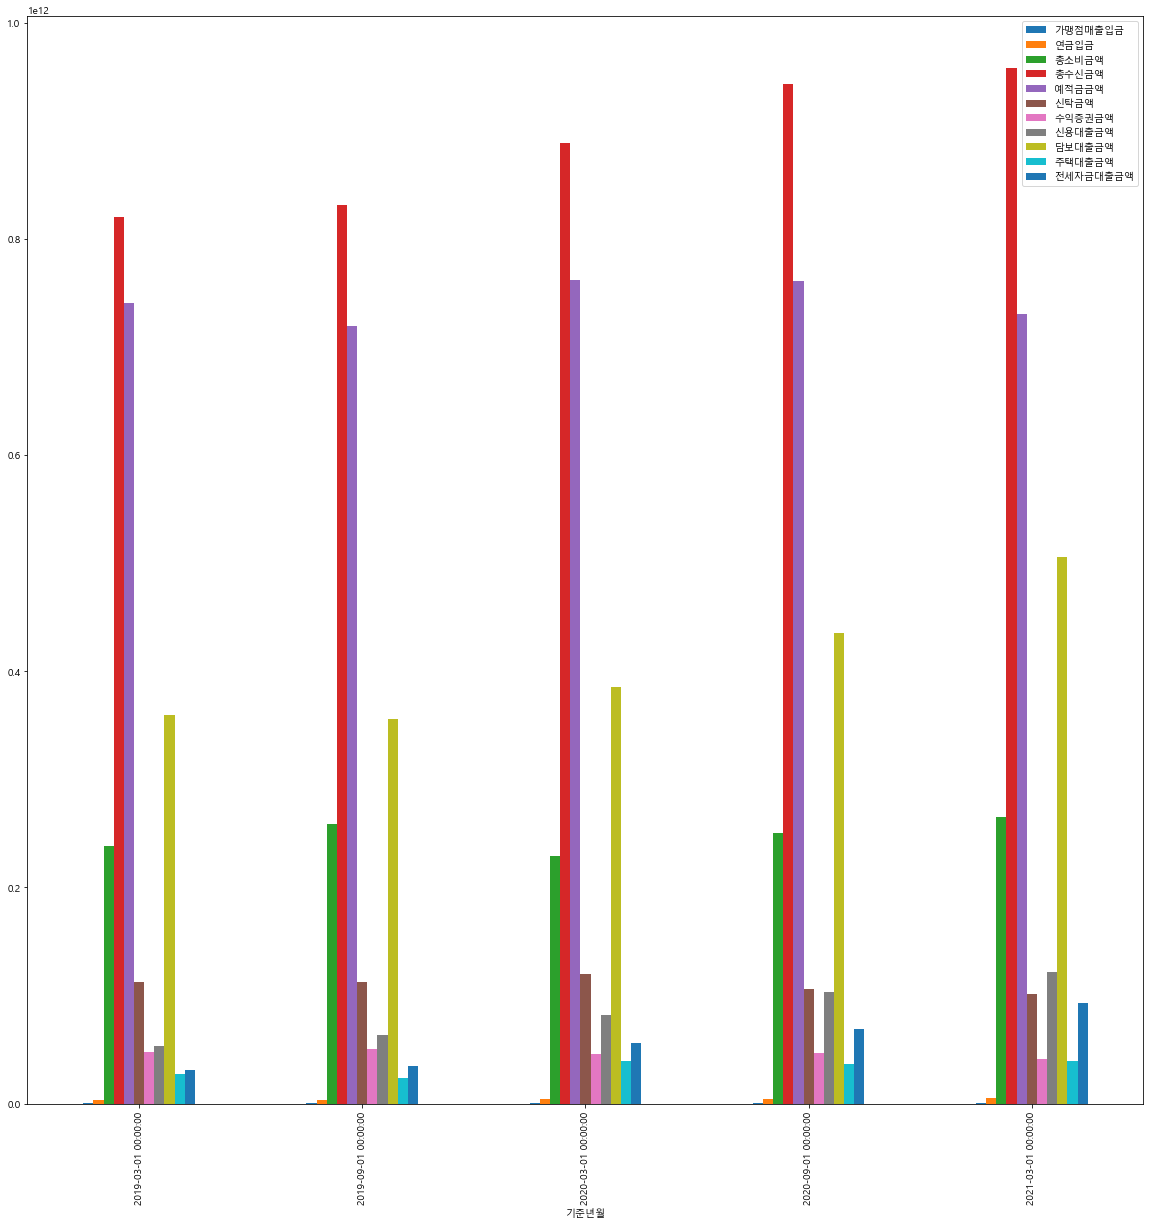

In [61]:
groupby_yr.plot.bar(x='기준년월',figsize=(20,20))

<AxesSubplot:xlabel='기준년월'>

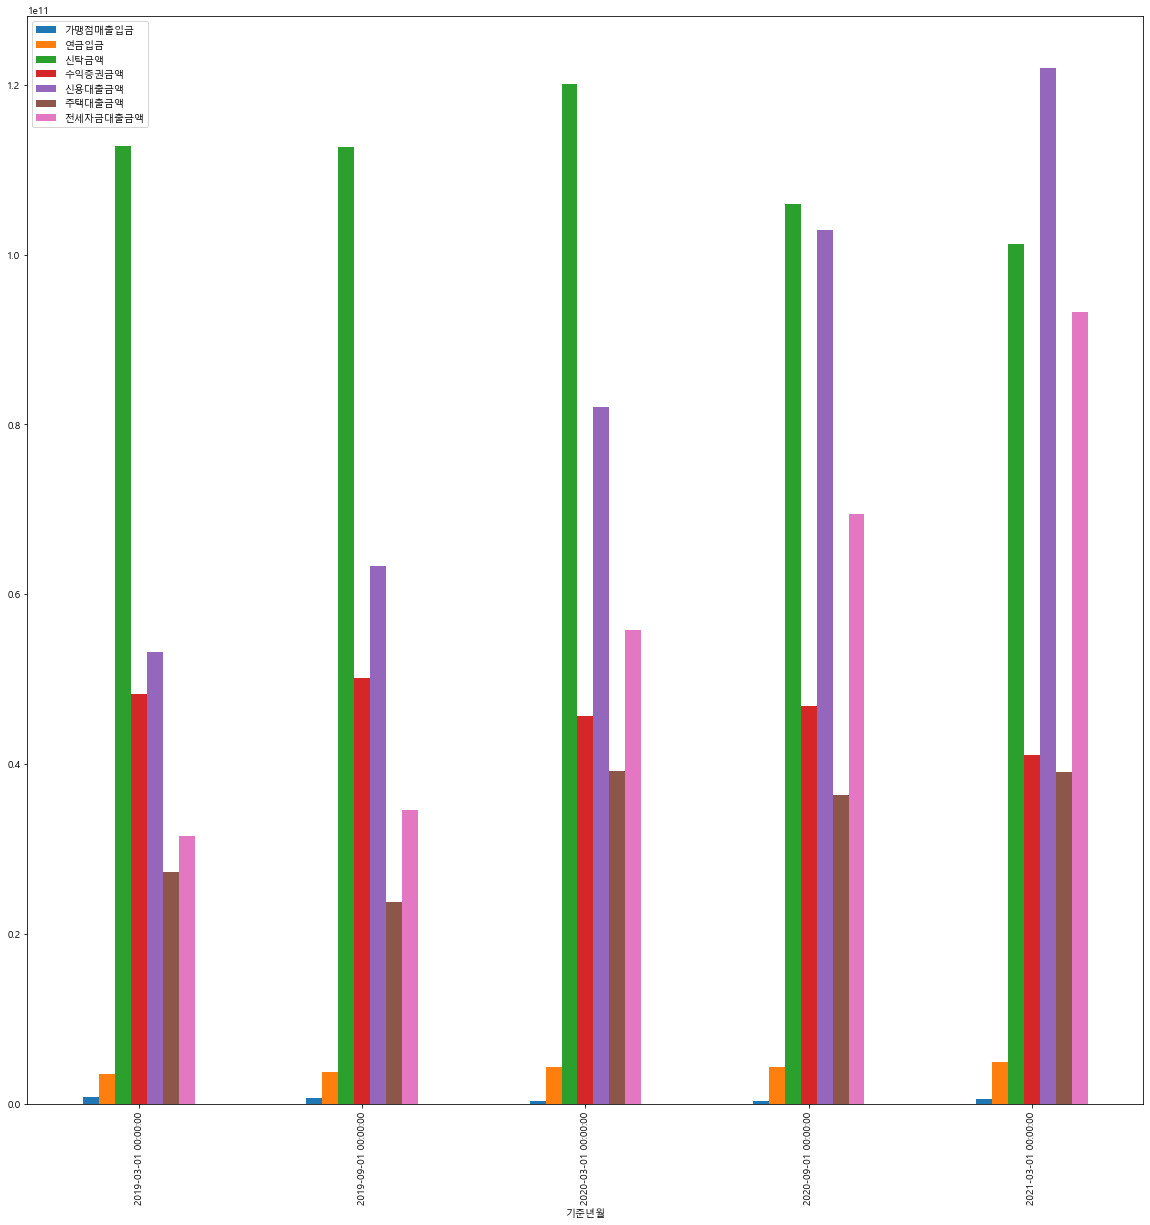

In [64]:
# 위의그림에서 단위가 작아 표현이 모호한 부분만 다시 확인합니다. 
groupby_yr[['기준년월','가맹점매출입금', '연금입금','신탁금액', '수익증권금액','신용대출금액','주택대출금액', '전세자금대출금액']].plot.bar(x='기준년월',figsize=(20,20))

<AxesSubplot:xlabel='기준년월'>

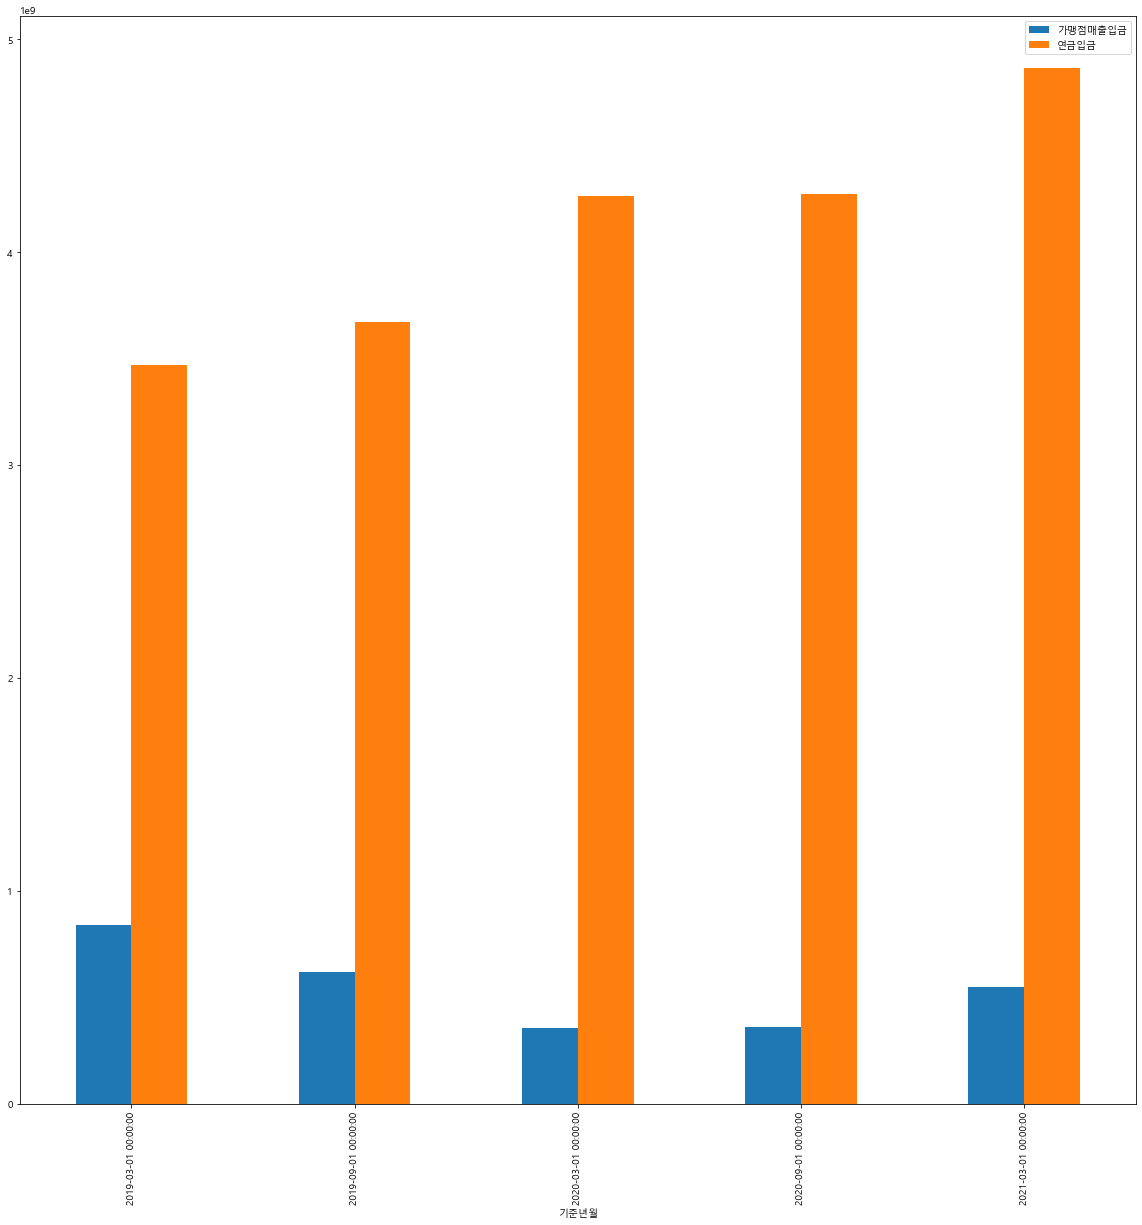

In [65]:
# 위의그림에서 단위가 작아 표현이 모호한 부분만 다시 확인합니다.
groupby_yr[['기준년월','가맹점매출입금', '연금입금']].plot.bar(x='기준년월',figsize=(20,20))

* 시간에 따른 변동률을 시각화 하기 위해, 데이터를 다시한번 처리하고 시각화를 진행합니다. 

* 연도별 전체 거래흐름 중 각 항목의 거래액의 비중 시각화 

In [156]:
groupby_yr.columns

Index(['기준년월', '가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액'],
      dtype='object')

In [160]:
features = ['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', 
            '신탁금액', '수익증권금액','신용대출금액', '담보대출금액', '주택대출금액', 
            '전세자금대출금액']

result_col = ['기준년월', '가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액','총거래액']


ratio_yr = pd.DataFrame(columns=result_col)
for idx, row in groupby_yr.iterrows():
    temp = []
    temp.append(row['기준년월'])
    
    total = 0
    for feature in features:
            total = total + row[feature]
            
    for feature in features:
            item = (row[feature]/total)
            temp.append(item)
    temp.append(total)
    ratio_yr= ratio_yr.append(pd.DataFrame([temp], columns=result_col),ignore_index=True)


In [163]:
ratio_yr

,기준년월,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,총거래액
0,2019-03-01,0.000345,0.001424,0.097773,0.336703,0.303968,0.046281,0.019804,0.021850,0.147757,0.011176,0.012919,2435975411163
1,2019-09-01,0.000252,0.001495,0.105351,0.338799,0.293133,0.045881,0.020413,0.025781,0.145109,0.009691,0.014096,2455167084822
2,2020-03-01,0.000136,0.001631,0.087702,0.340052,0.291822,0.045955,0.017485,0.031391,0.147494,0.014998,0.021333,2612554261056
3,2020-09-01,0.000130,0.001551,0.090889,0.342267,0.276174,0.038450,0.016986,0.037323,0.157854,0.013180,0.025196,2755944081944
4,2021-03-01,0.000191,0.001700,0.092795,0.334807,0.255281,0.035369,0.014369,0.042618,0.176611,0.013671,0.032588,2861378039053


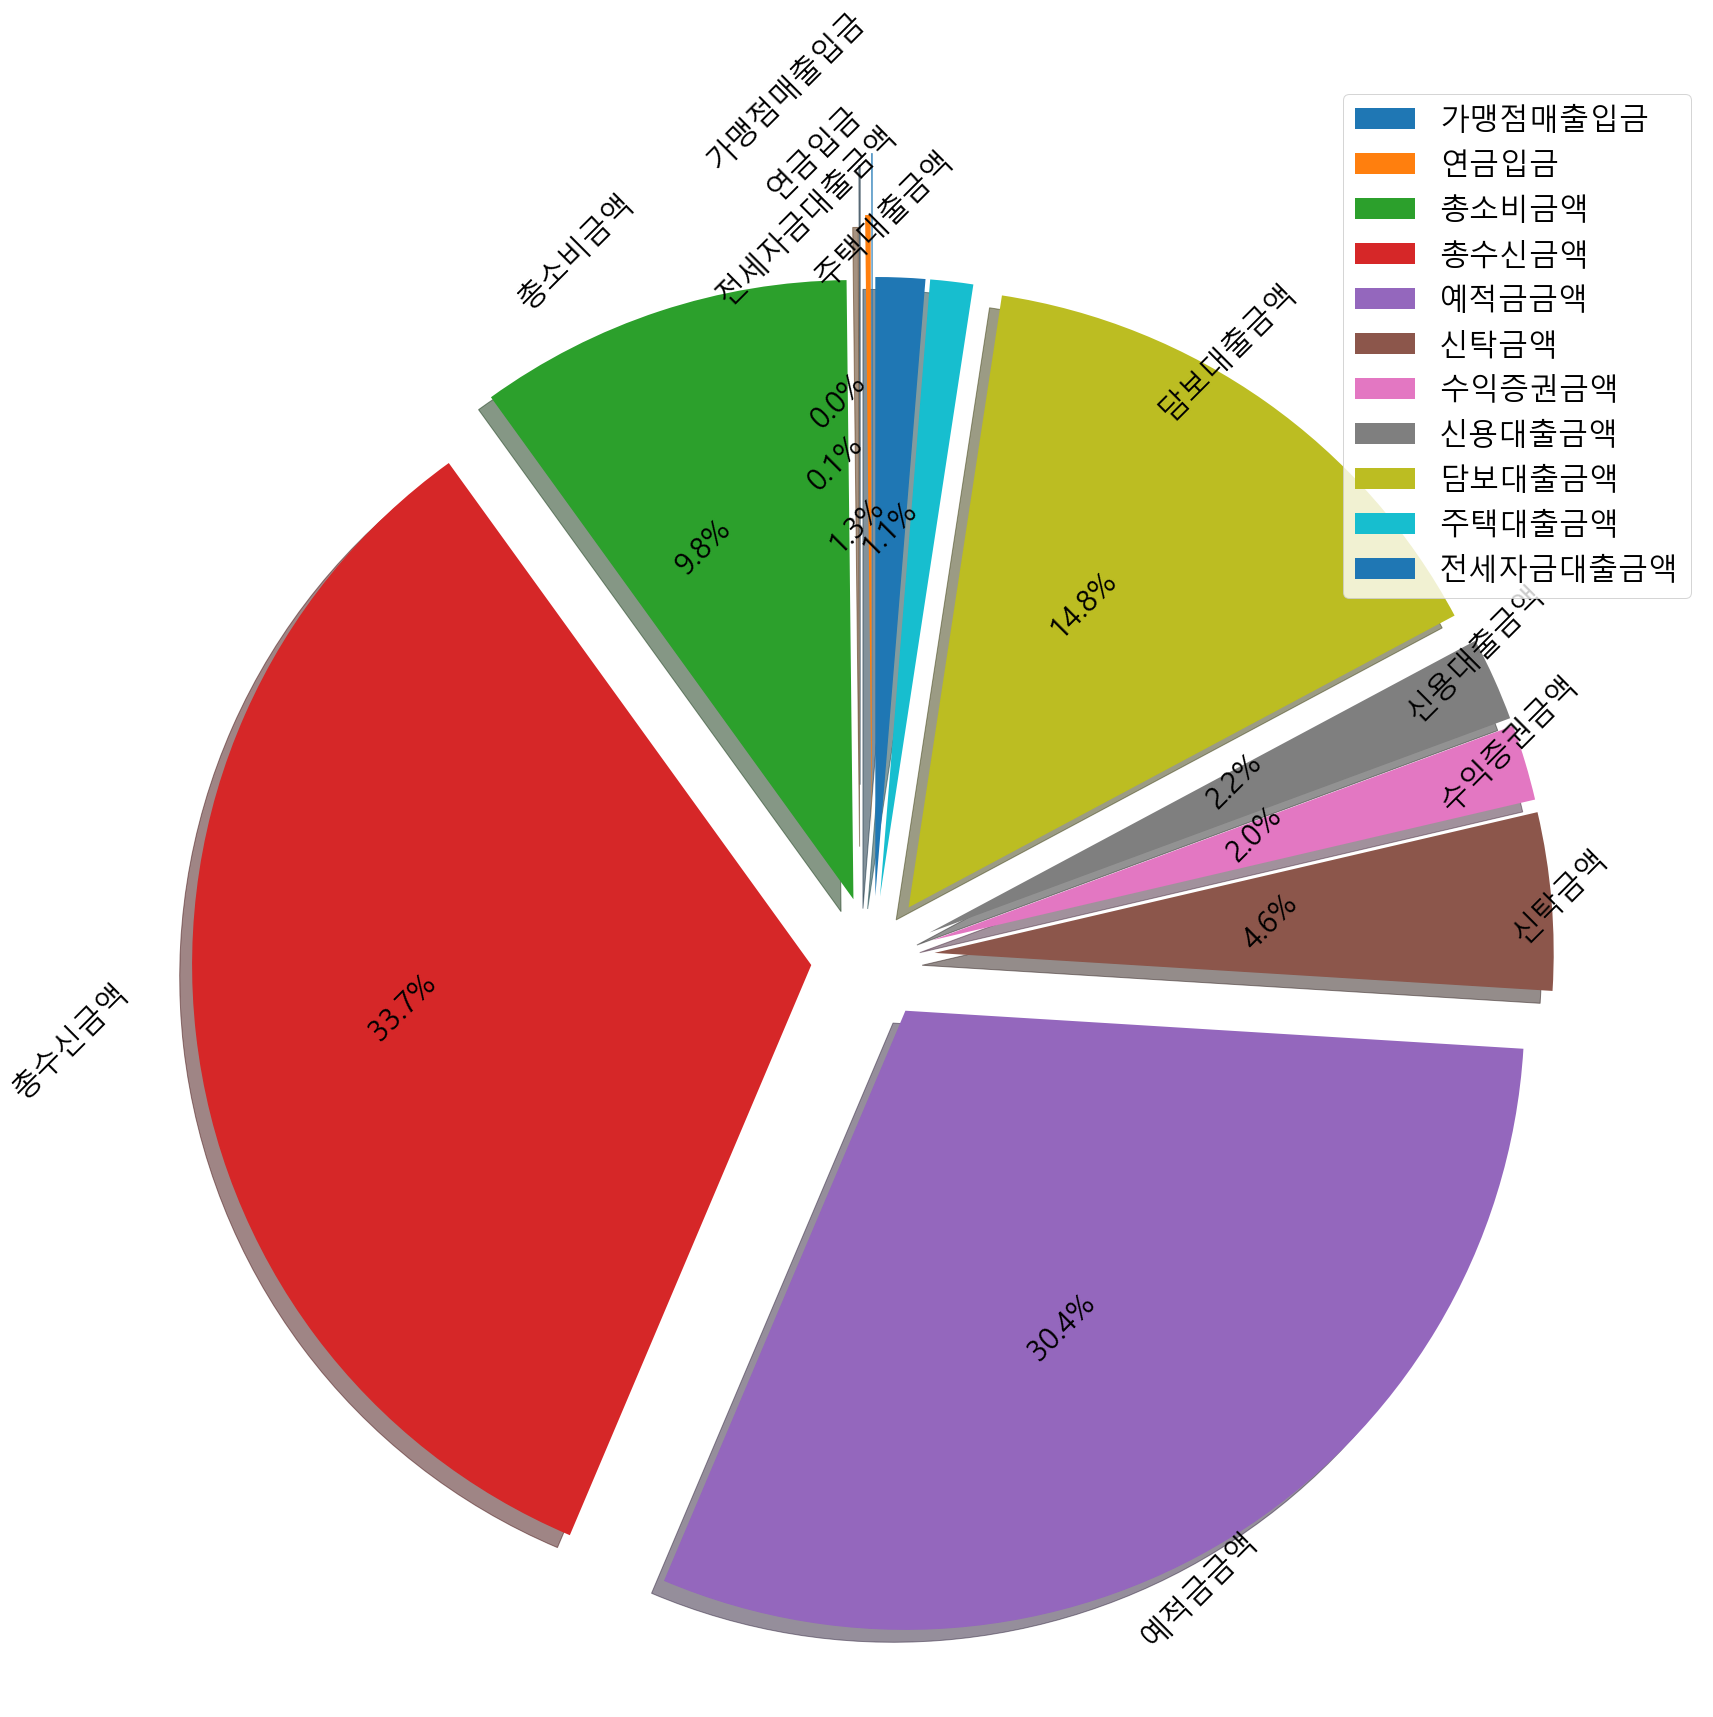

In [214]:
plt.figure(figsize=(30,30))
explode = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# colors = 

plt.pie(ratio_yr.iloc[0, 1:12],labels= features,  shadow=True, startangle=90, 
        autopct='%1.1f%%', textprops={'size': 30, 'rotation':45, 'ha':'right'}, explode=explode)
plt.legend(features, loc='best',fontsize=30)
plt.axis('equal')
plt.show()

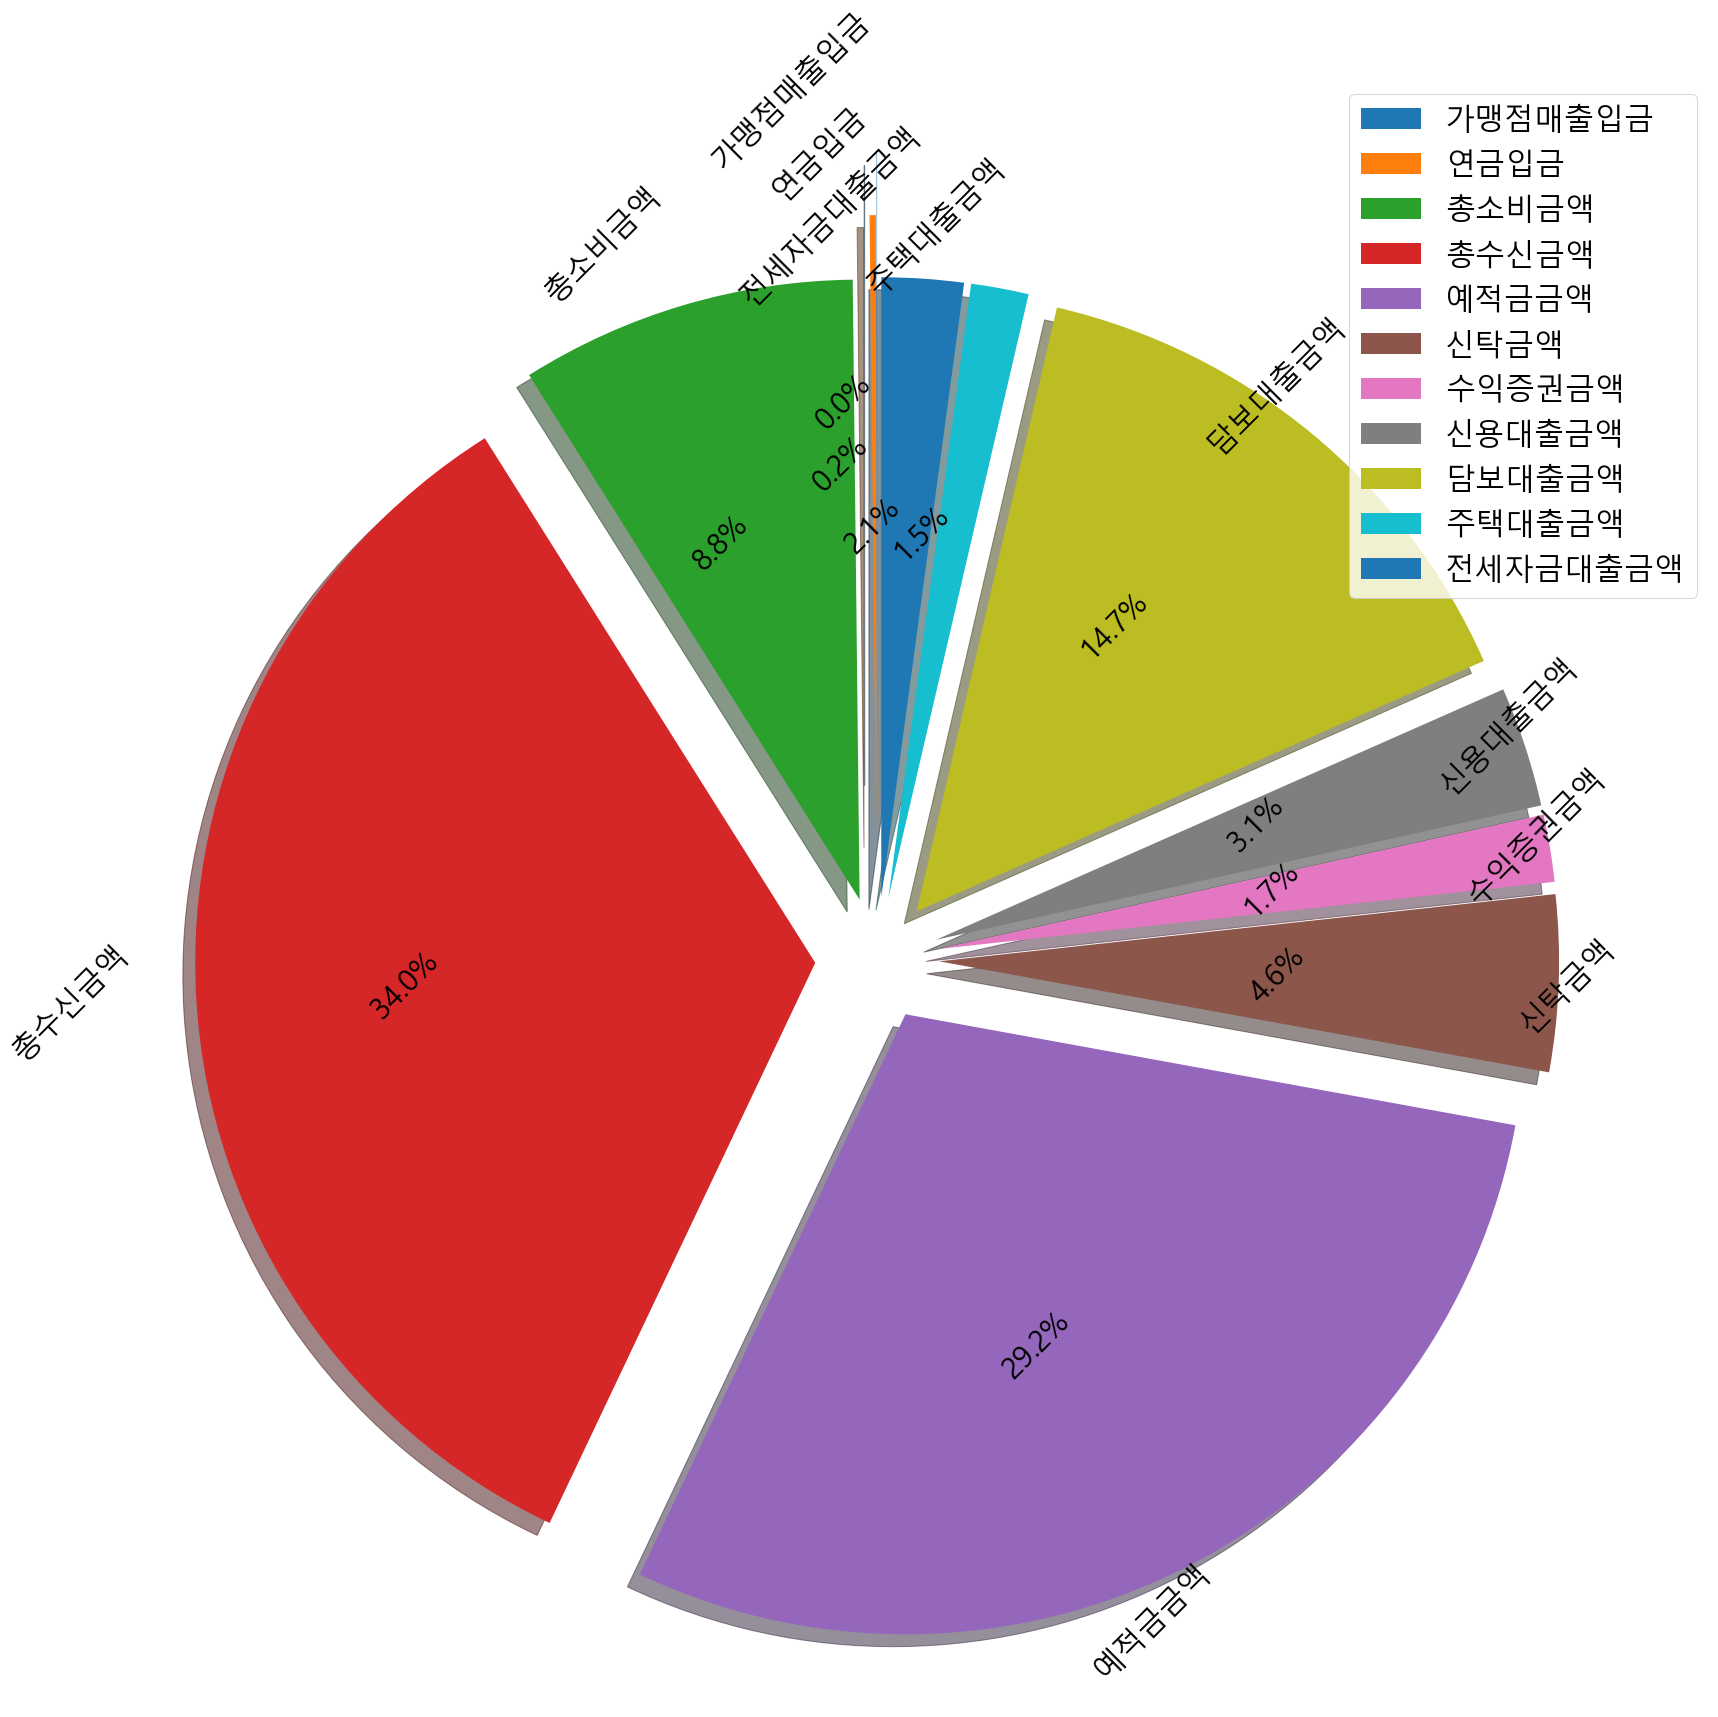

In [220]:
plt.figure(figsize=(30,30))
explode = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# colors = 

plt.pie(ratio_yr.iloc[2, 1:12],labels= features,  shadow=True, startangle=90, 
        autopct='%1.1f%%', textprops={'size': 30, 'rotation':45, 'ha':'right'}, explode=explode)
plt.legend(features, loc='best',fontsize=30)
plt.axis('equal')
plt.show()

In [219]:
for i in range(0,5):
    print(ratio_yr.iloc[i, 1:12].sort_values())

가맹점매출입금     0.000345
연금입금        0.001424
주택대출금액      0.011176
전세자금대출금액    0.012919
수익증권금액      0.019804
신용대출금액       0.02185
신탁금액        0.046281
총소비금액       0.097773
담보대출금액      0.147757
예적금금액       0.303968
총수신금액       0.336703
Name: 0, dtype: object
가맹점매출입금     0.000252
연금입금        0.001495
주택대출금액      0.009691
전세자금대출금액    0.014096
수익증권금액      0.020413
신용대출금액      0.025781
신탁금액        0.045881
총소비금액       0.105351
담보대출금액      0.145109
예적금금액       0.293133
총수신금액       0.338799
Name: 1, dtype: object
가맹점매출입금     0.000136
연금입금        0.001631
주택대출금액      0.014998
수익증권금액      0.017485
전세자금대출금액    0.021333
신용대출금액      0.031391
신탁금액        0.045955
총소비금액       0.087702
담보대출금액      0.147494
예적금금액       0.291822
총수신금액       0.340052
Name: 2, dtype: object
가맹점매출입금      0.00013
연금입금        0.001551
주택대출금액       0.01318
수익증권금액      0.016986
전세자금대출금액    0.025196
신용대출금액      0.037323
신탁금액         0.03845
총소비금액       0.090889
담보대출금액      0.157854
예적금금액       0.276174
총수신금액       0.342267
Name: 3

* 2020년 3월 부터 전체 거래량 비중에서 전세자금 대출액의 거래규모가 수익증권금액의 규모를 역전했다. 

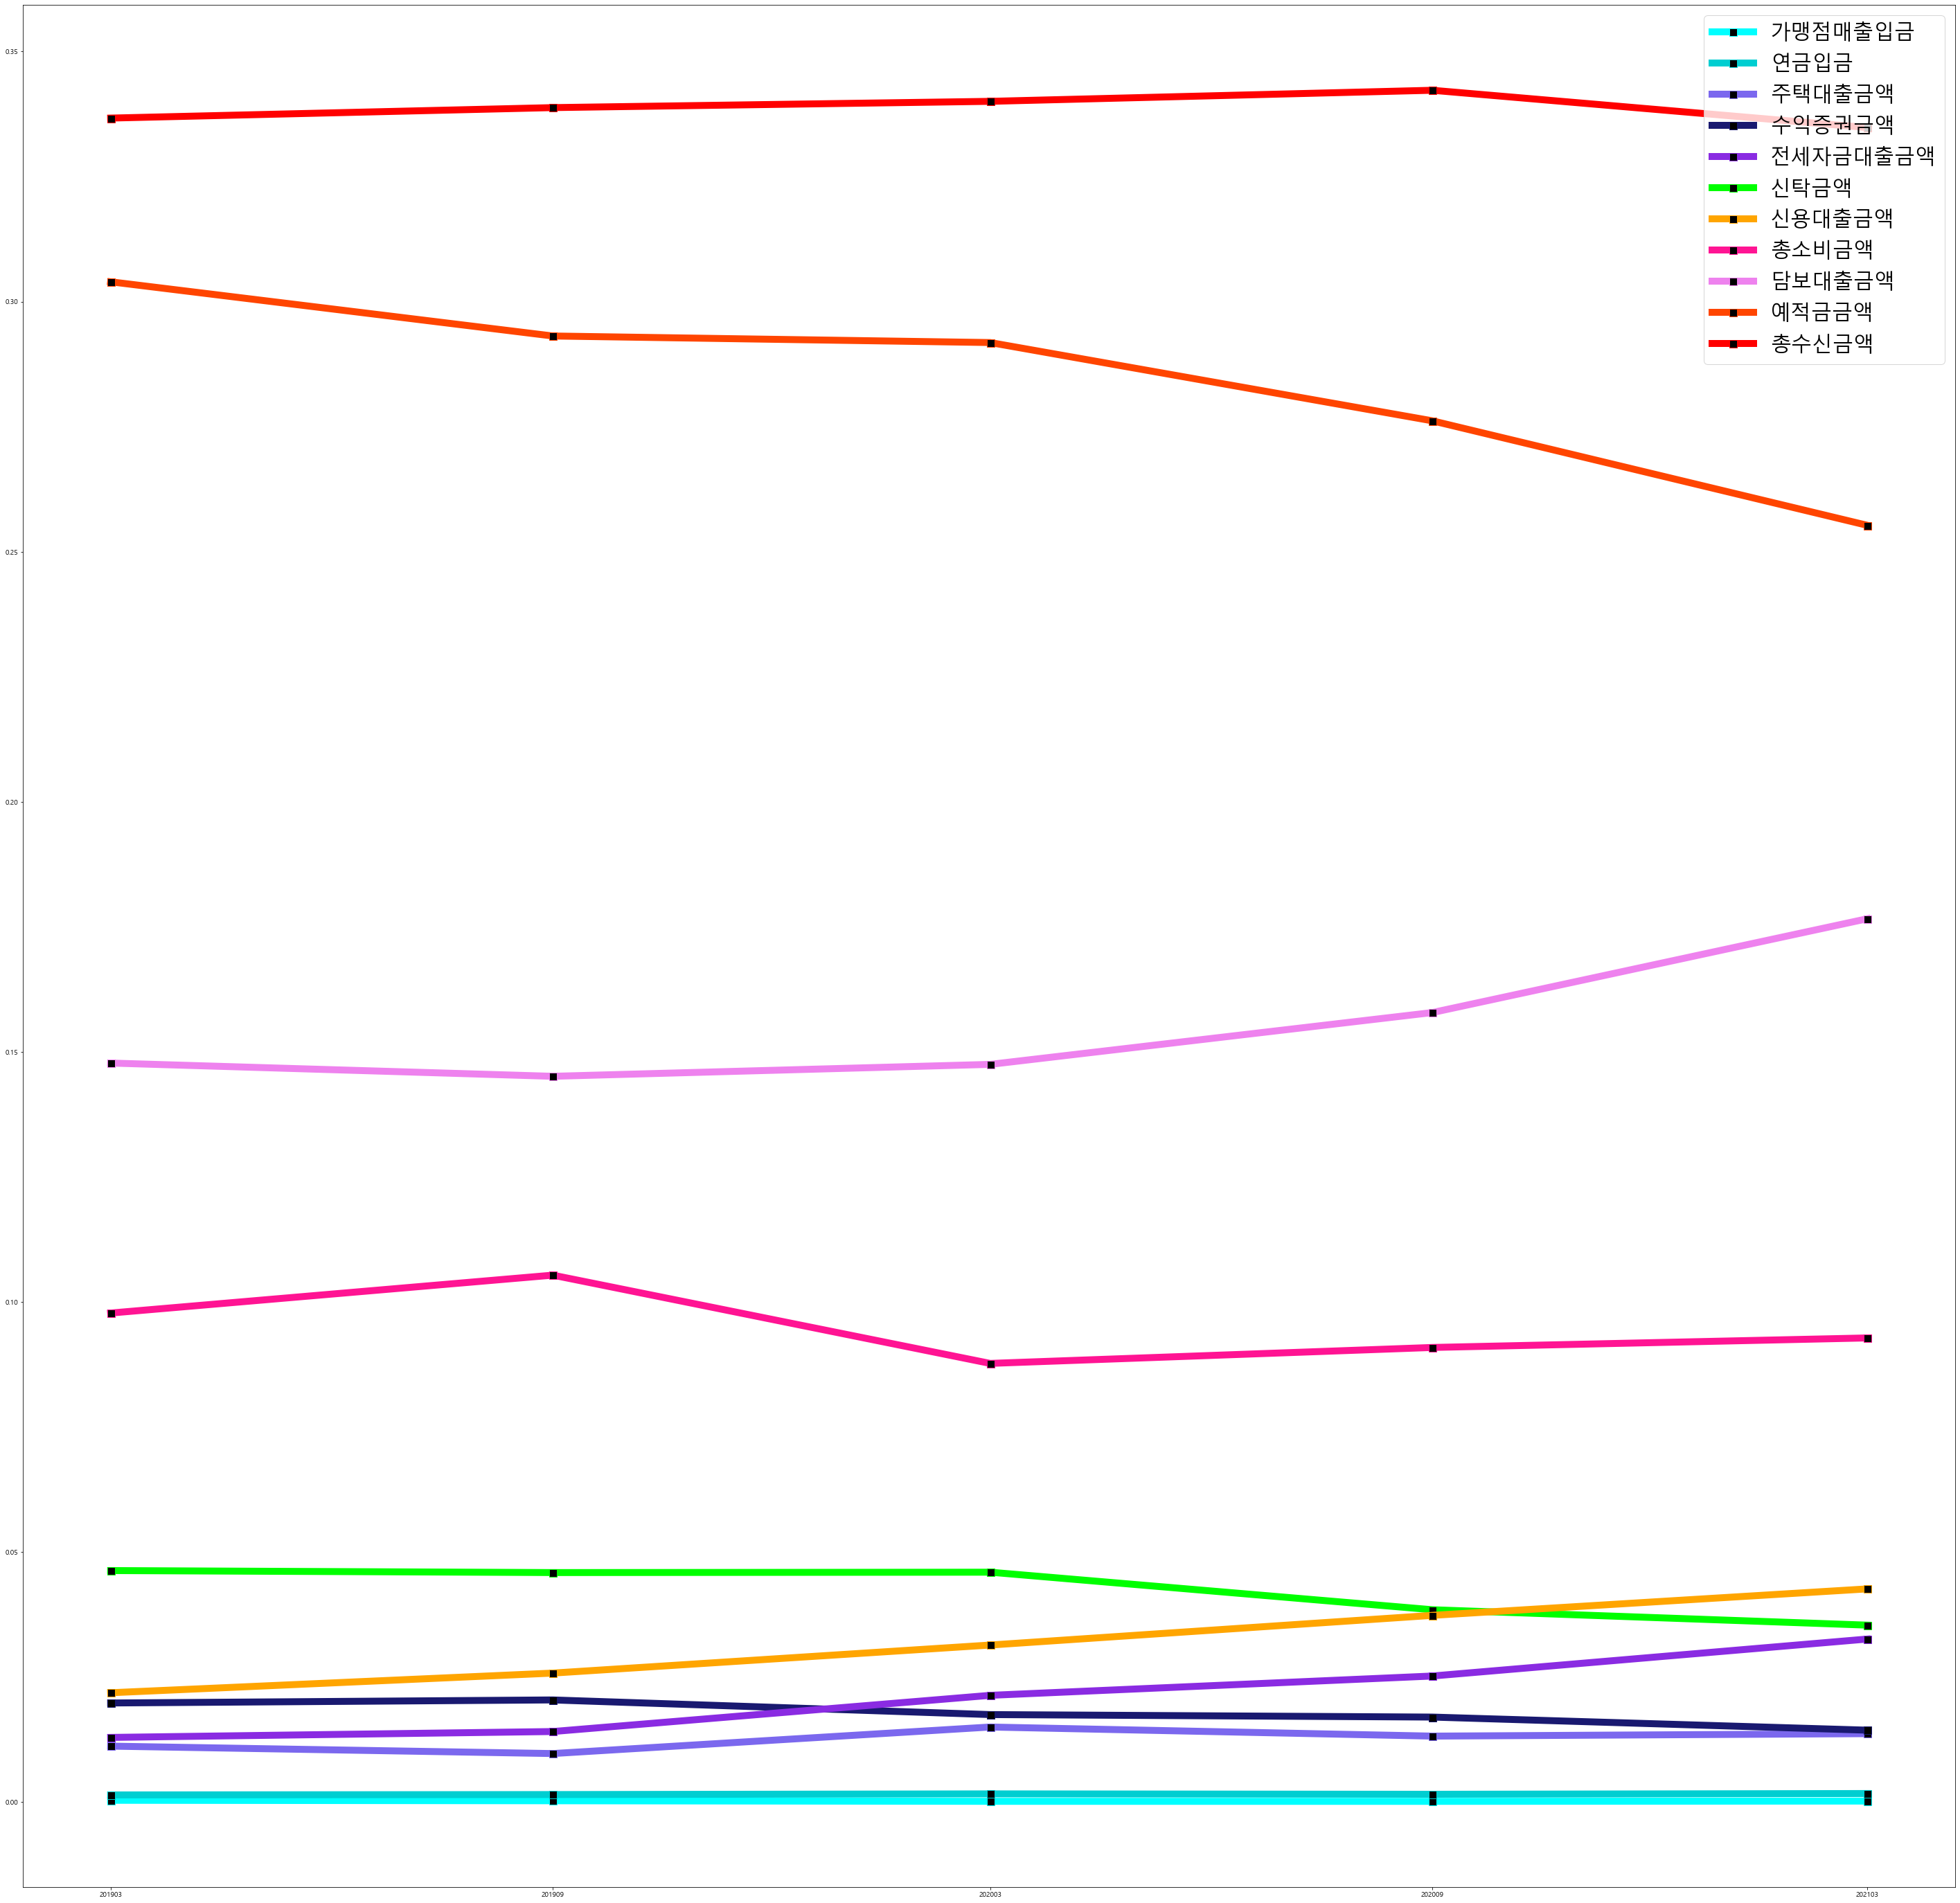

In [256]:
plt.figure(figsize=(50,50))
plt.plot(ratio_yr.기준년월, ratio_yr.가맹점매출입금,marker='s', color='cyan', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.연금입금,marker='s', color='darkturquoise', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.주택대출금액,marker='s', color='mediumslateblue', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.수익증권금액,marker='s', color='midnightblue', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.전세자금대출금액,marker='s', color='blueviolet', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.신탁금액,marker='s', color='lime', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.신용대출금액,marker='s', color='orange', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.총소비금액,marker='s', color='deeppink', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.담보대출금액,marker='s', color='violet', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.예적금금액,marker='s', color='orangered', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.총수신금액,marker='s', color='r', linewidth=10, markersize=11, markerfacecolor='black')


# plt.set_xticks(['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
#        '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
#        '2021-03-01T00:00:00.000000000'])
plt.xticks(ticks=['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'],labels=['201903','201909','202003','202009','202103'])
plt.legend(['가맹점매출입금','연금입금','주택대출금액','수익증권금액',
            '전세자금대출금액','신탁금액','신용대출금액','총소비금액',
            '담보대출금액','예적금금액','총수신금액'], loc='best',fontsize=30)

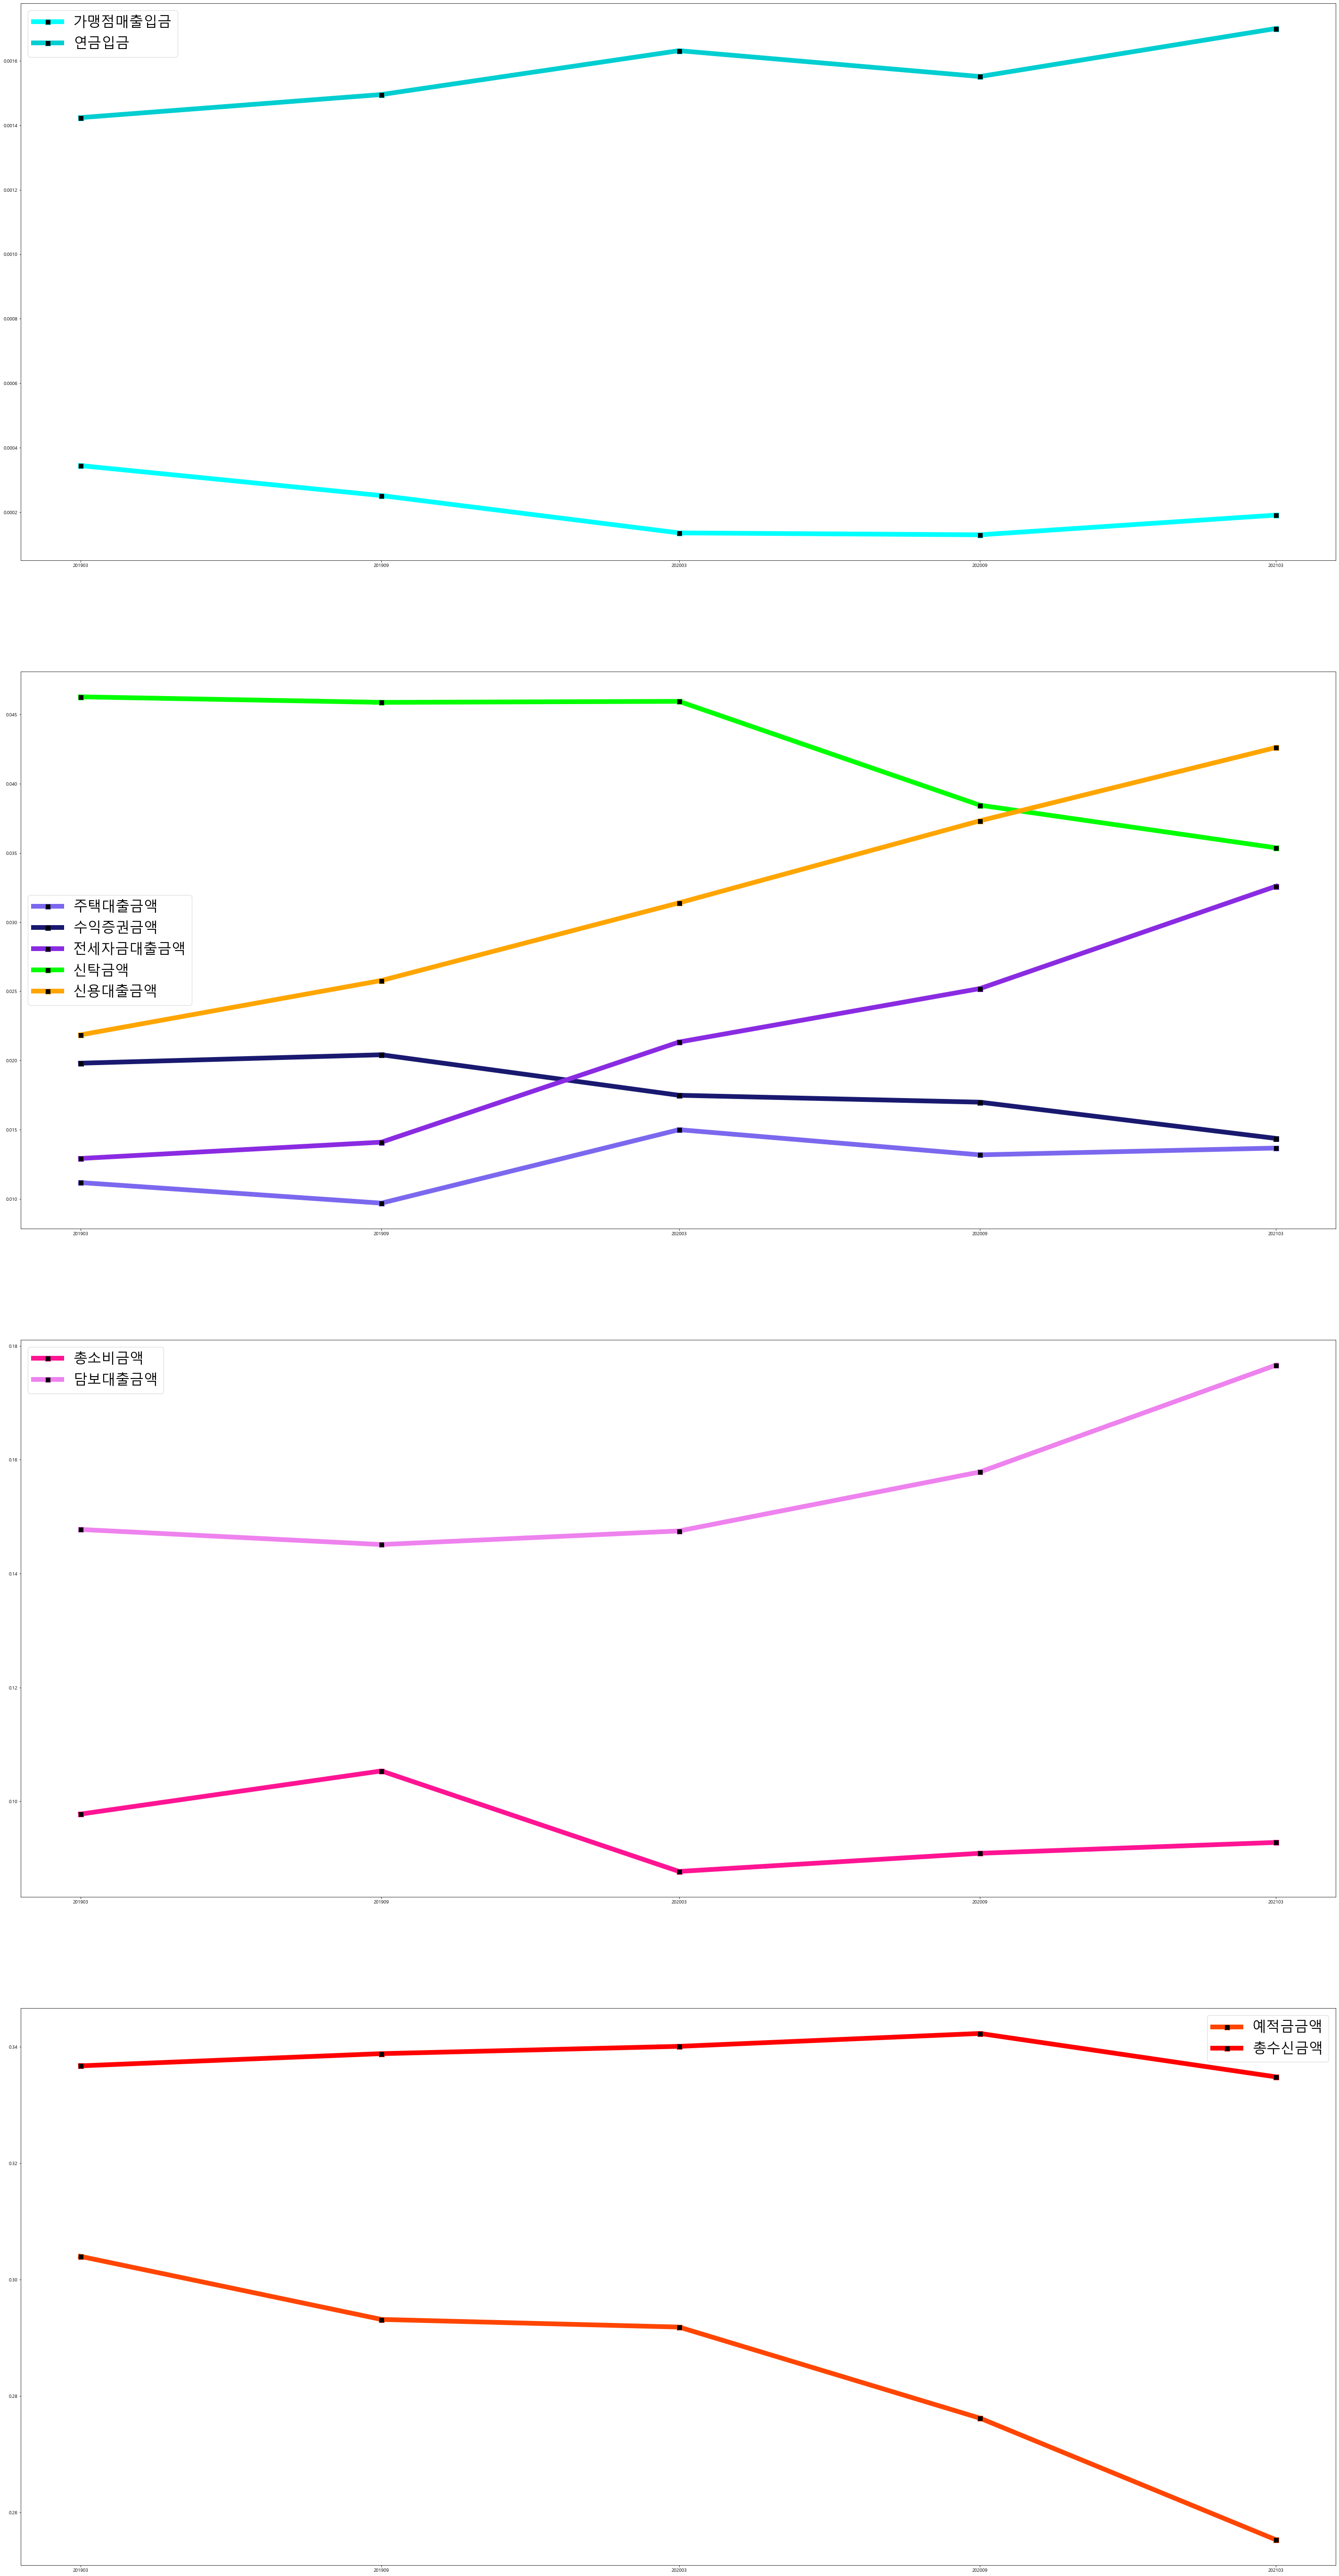

In [245]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, figsize=(50,100))

ax1.plot(ratio_yr.기준년월, ratio_yr.가맹점매출입금,marker='s', color='cyan', linewidth=10, markersize=11, markerfacecolor='black')
ax1.plot(ratio_yr.기준년월, ratio_yr.연금입금,marker='s', color='darkturquoise', linewidth=10, markersize=11, markerfacecolor='black')
ax1.set_xticks(['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'])
ax1.set_xticklabels(['201903','201909','202003','202009','202103'])
ax1.legend(['가맹점매출입금','연금입금'], loc='best',fontsize=30)

ax2.plot(ratio_yr.기준년월, ratio_yr.주택대출금액,marker='s', color='mediumslateblue', linewidth=10, markersize=11, markerfacecolor='black')
ax2.plot(ratio_yr.기준년월, ratio_yr.수익증권금액,marker='s', color='midnightblue', linewidth=10, markersize=11, markerfacecolor='black')
ax2.plot(ratio_yr.기준년월, ratio_yr.전세자금대출금액,marker='s', color='blueviolet', linewidth=10, markersize=11, markerfacecolor='black')
ax2.plot(ratio_yr.기준년월, ratio_yr.신탁금액,marker='s', color='lime', linewidth=10, markersize=11, markerfacecolor='black')
ax2.plot(ratio_yr.기준년월, ratio_yr.신용대출금액,marker='s', color='orange', linewidth=10, markersize=11, markerfacecolor='black')
ax2.set_xticks(['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'])
ax2.set_xticklabels(['201903','201909','202003','202009','202103'])
ax2.legend(['주택대출금액','수익증권금액','전세자금대출금액','신탁금액','신용대출금액'], loc='best',fontsize=30)


ax3.plot(ratio_yr.기준년월, ratio_yr.총소비금액,marker='s', color='deeppink', linewidth=10, markersize=11, markerfacecolor='black')
ax3.plot(ratio_yr.기준년월, ratio_yr.담보대출금액,marker='s', color='violet', linewidth=10, markersize=11, markerfacecolor='black')
ax3.set_xticks(['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'])
ax3.set_xticklabels(['201903','201909','202003','202009','202103'])
ax3.legend(['총소비금액','담보대출금액'], loc='best',fontsize=30)

ax4.plot(ratio_yr.기준년월, ratio_yr.예적금금액,marker='s', color='orangered', linewidth=10, markersize=11, markerfacecolor='black')
ax4.plot(ratio_yr.기준년월, ratio_yr.총수신금액,marker='s', color='r', linewidth=10, markersize=11, markerfacecolor='black')
ax4.set_xticks(['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'])
ax4.set_xticklabels(['201903','201909','202003','202009','202103'])
ax4.legend(['예적금금액','총수신금액'], loc='best',fontsize=30)

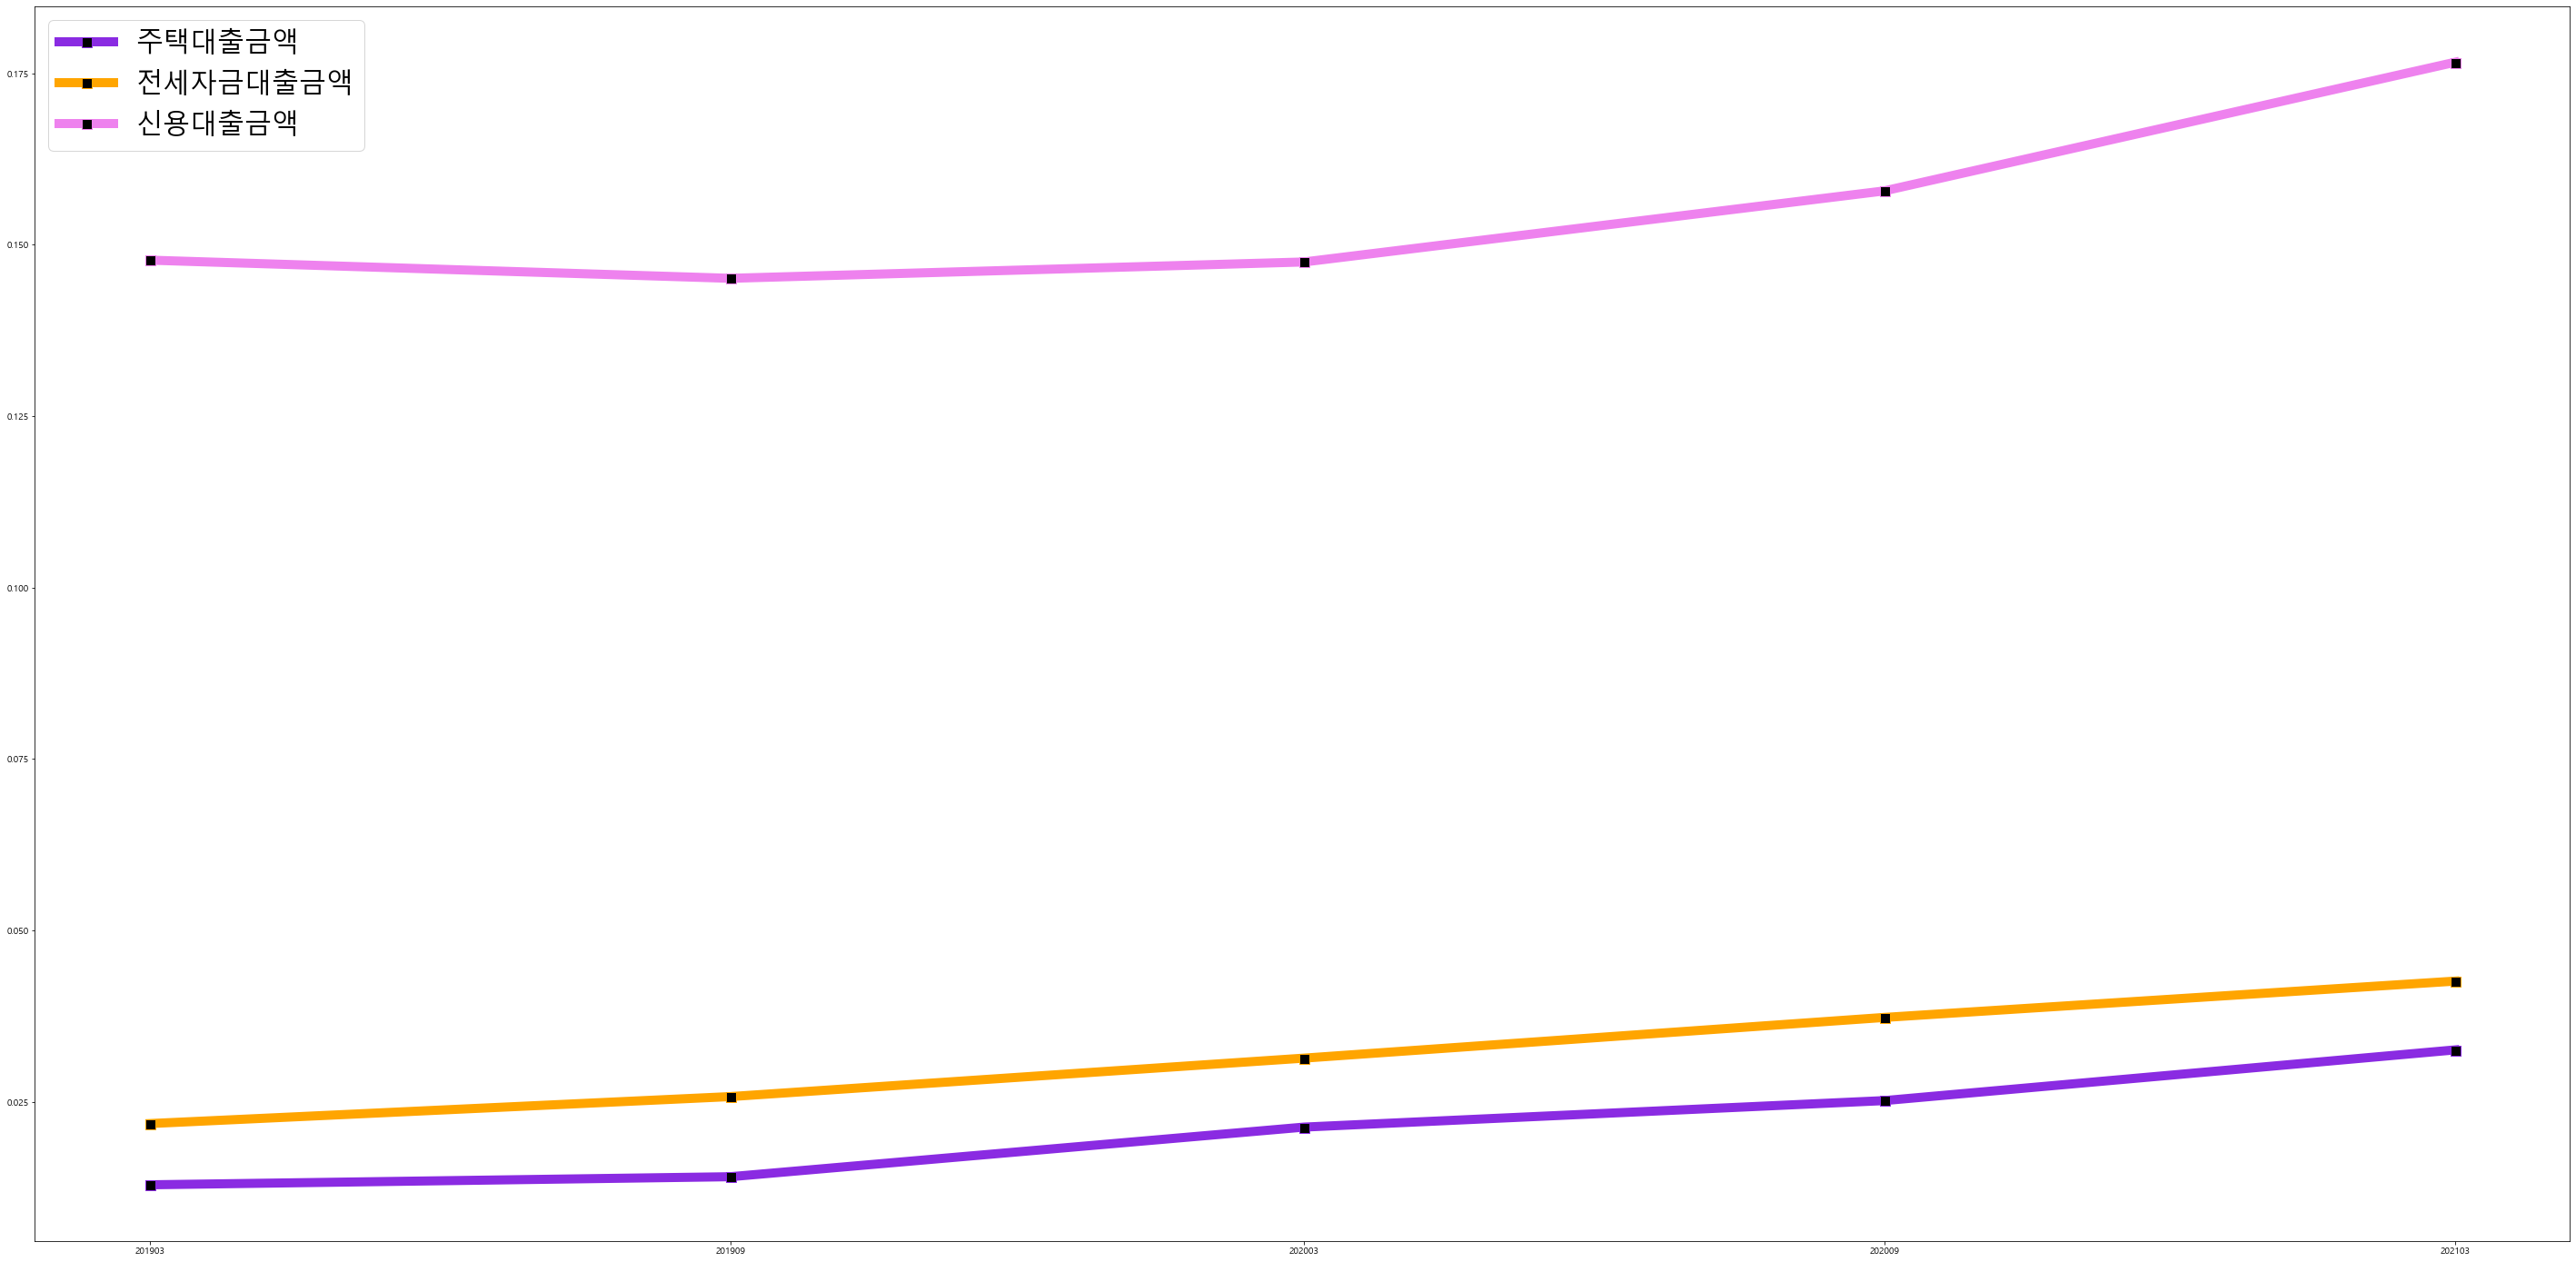

In [258]:
plt.figure(figsize=(50,25))
plt.plot(ratio_yr.기준년월, ratio_yr.전세자금대출금액,marker='s', color='blueviolet', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.신용대출금액,marker='s', color='orange', linewidth=10, markersize=11, markerfacecolor='black')
plt.plot(ratio_yr.기준년월, ratio_yr.담보대출금액,marker='s', color='violet', linewidth=10, markersize=11, markerfacecolor='black')

plt.xticks(ticks=['2019-03-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'],labels=['201903','201909','202003','202009','202103'])
plt.legend(['주택대출금액','전세자금대출금액','신용대출금액'], loc='best',fontsize=30)

* 주택담보대출액을 제외한 주택, 전세, 신용 세가지의 대출 유형 모두 증가 

**해당 변동이 어느 지역 혹은 연령등의 구분에서 발생했는지 더욱 알아봅니다.**

## 지역별 분석 

* 구별 분석 -> 동별분석 
* 각 구별, 시점별 비중이나 변동 확인 후 시각화 
* 변동이 큰 구에 대해 조금 더 자세히 

In [265]:
import folium
import json
import requests
import branca
from branca.colormap import linear
from folium import plugins

### 지역구별 분석 

In [260]:
groupby_gu = sinhan.groupby(['기준년월','지역구'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액'].sum().reset_index()
groupby_gu

<ipython-input-260-b6d6125cab8e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupby_gu = sinhan.groupby(['기준년월','지역구'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',


,기준년월,지역구,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,2019-03-01,강남구,173412507,365400221,16626306023,66265751376,66780046022,29969789931,13146476407,8398123775,52879247332,3720550086,1732694789
1,2019-03-01,강동구,84242683,118722105,9915572200,31900758352,29806888712,2422721467,710585983,1995387250,16417044601,1131388012,1914048349
2,2019-03-01,강북구,5653934,82524896,6551953668,18682877550,12628997836,291664029,106076954,296691578,1520066566,229694008,0
3,2019-03-01,강서구,10559121,267245011,14346285799,46769935605,41318295318,3602488309,1739623066,4506563397,29945374971,903776072,7976047537
4,2019-03-01,관악구,0,141147592,11678424939,36141077411,31773566547,746121608,297621929,1361769862,7048991333,390791675,785667972
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2021-03-01,용산구,18695544,167562448,7584354899,27368154427,22655128365,5171537223,3573729278,4160674619,15771981629,312357166,2230641179
121,2021-03-01,은평구,10263394,232881278,12324084480,39809952364,31002213340,1100051283,411047788,2558517675,17824555171,1318945966,2375551423
122,2021-03-01,종로구,5493582,77978619,4491112168,17084454231,11234418377,1712180588,656760950,2190165028,5449028651,538145372,665040000
123,2021-03-01,중구,43605712,74340911,4155109598,14593820095,11492089990,1094708366,356598858,1833526322,10433414708,706965444,238839897


In [261]:
# 각 지역구의 평균적인 거래 정보를 산출합니다.  
groupby_gu_mean= groupby_gu.groupby(['지역구'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',
       '신용대출금액', '담보대출금액', '주택대출금액', '전세자금대출금액'].mean().reset_index()

<ipython-input-261-91959296d190>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupby_gu_mean= groupby_gu.groupby(['지역구'])['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', '신탁금액', '수익증권금액',


In [262]:
groupby_gu_mean

,지역구,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액
0,강남구,97289927.4,383734347.8,1.764281e+10,7.274105e+10,6.700719e+10,2.908531e+10,1.280537e+10,1.136618e+10,4.988484e+10,3.455814e+09,2.817801e+09
1,강동구,45839906.4,156850826.0,1.047034e+10,3.596225e+10,3.159300e+10,2.364603e+09,8.271457e+08,3.809934e+09,1.775742e+10,2.136634e+09,1.431676e+09
2,강북구,6115538.6,91832440.6,6.773368e+09,1.993318e+10,1.276773e+10,1.629113e+08,5.132320e+07,3.622221e+08,1.837332e+09,6.176850e+07,5.785333e+07
3,강서구,5905230.6,313044651.4,1.505123e+10,5.115208e+10,4.230468e+10,3.330847e+09,1.584532e+09,6.962561e+09,3.998686e+10,7.887969e+08,1.513835e+10
4,관악구,1237154.6,159706280.2,1.222530e+10,3.899937e+10,3.240677e+10,6.919208e+08,2.622962e+08,2.050796e+09,1.271516e+10,3.910951e+08,2.620745e+09
5,광진구,7612697.6,71399290.0,8.652355e+09,2.968517e+10,2.274808e+10,3.225747e+09,1.358430e+09,1.868676e+09,1.008436e+10,7.240312e+08,6.505247e+08
6,구로구,8701516.8,159728864.2,9.286095e+09,3.121683e+10,2.590678e+10,1.358441e+09,5.325979e+08,2.146064e+09,1.669865e+10,8.555755e+08,3.068626e+09
7,금천구,15847253.2,72652850.4,5.450528e+09,1.550907e+10,1.383739e+10,2.631427e+08,6.880709e+07,4.394190e+08,1.283745e+10,1.889322e+09,2.985300e+09
8,노원구,19522554.0,245253752.6,1.205044e+10,4.242653e+10,3.583423e+10,2.762041e+09,6.697655e+08,4.929753e+09,1.027494e+10,8.476187e+08,1.193832e+09
9,도봉구,4119584.0,222661758.2,8.433355e+09,2.795757e+10,2.558741e+10,1.496183e+09,3.814308e+08,4.840948e+08,5.263320e+09,3.360979e+08,3.221549e+07


In [263]:
features = ['가맹점매출입금', '연금입금', '총소비금액', '총수신금액', '예적금금액', 
            '신탁금액', '수익증권금액','신용대출금액', '담보대출금액', '주택대출금액', 
            '전세자금대출금액']

groupby_gu_mean['총거래량'] = np.nan
for idx, row in groupby_gu_mean.iterrows():
    total = 0
    for feature in features:
        total = total + row[feature]
    groupby_gu_mean['총거래량'][idx] = total
    

<ipython-input-263-73c389363440>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupby_gu_mean['총거래량'][idx] = total


In [264]:
groupby_gu_mean

,지역구,가맹점매출입금,연금입금,총소비금액,총수신금액,예적금금액,신탁금액,수익증권금액,신용대출금액,담보대출금액,주택대출금액,전세자금대출금액,총거래량
0,강남구,97289927.4,383734347.8,1.764281e+10,7.274105e+10,6.700719e+10,2.908531e+10,1.280537e+10,1.136618e+10,4.988484e+10,3.455814e+09,2.817801e+09,2.672874e+11
1,강동구,45839906.4,156850826.0,1.047034e+10,3.596225e+10,3.159300e+10,2.364603e+09,8.271457e+08,3.809934e+09,1.775742e+10,2.136634e+09,1.431676e+09,1.065557e+11
2,강북구,6115538.6,91832440.6,6.773368e+09,1.993318e+10,1.276773e+10,1.629113e+08,5.132320e+07,3.622221e+08,1.837332e+09,6.176850e+07,5.785333e+07,4.210564e+10
3,강서구,5905230.6,313044651.4,1.505123e+10,5.115208e+10,4.230468e+10,3.330847e+09,1.584532e+09,6.962561e+09,3.998686e+10,7.887969e+08,1.513835e+10,1.766189e+11
4,관악구,1237154.6,159706280.2,1.222530e+10,3.899937e+10,3.240677e+10,6.919208e+08,2.622962e+08,2.050796e+09,1.271516e+10,3.910951e+08,2.620745e+09,1.025244e+11
5,광진구,7612697.6,71399290.0,8.652355e+09,2.968517e+10,2.274808e+10,3.225747e+09,1.358430e+09,1.868676e+09,1.008436e+10,7.240312e+08,6.505247e+08,7.907640e+10
6,구로구,8701516.8,159728864.2,9.286095e+09,3.121683e+10,2.590678e+10,1.358441e+09,5.325979e+08,2.146064e+09,1.669865e+10,8.555755e+08,3.068626e+09,9.123809e+10
7,금천구,15847253.2,72652850.4,5.450528e+09,1.550907e+10,1.383739e+10,2.631427e+08,6.880709e+07,4.394190e+08,1.283745e+10,1.889322e+09,2.985300e+09,5.336892e+10
8,노원구,19522554.0,245253752.6,1.205044e+10,4.242653e+10,3.583423e+10,2.762041e+09,6.697655e+08,4.929753e+09,1.027494e+10,8.476187e+08,1.193832e+09,1.112539e+11
9,도봉구,4119584.0,222661758.2,8.433355e+09,2.795757e+10,2.558741e+10,1.496183e+09,3.814308e+08,4.840948e+08,5.263320e+09,3.360979e+08,3.221549e+07,7.019845e+10


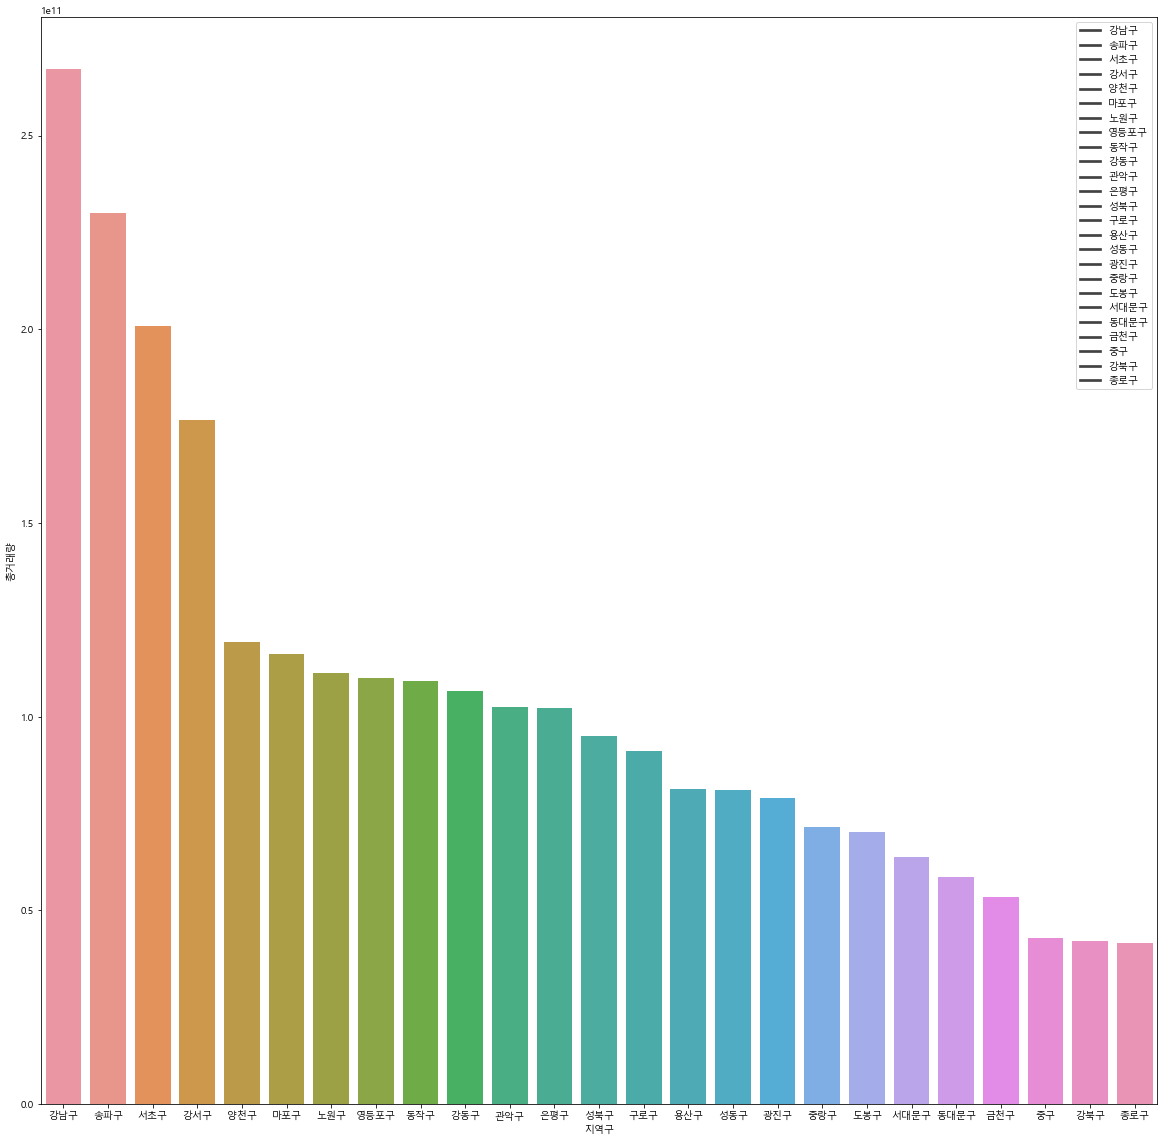

In [272]:
plt.figure(figsize=(20,20))
sns.barplot(x='지역구', y='총거래량', data=groupby_gu_mean.sort_values(by='총거래량',ascending=False))
plt.legend(groupby_gu_mean.sort_values(by='총거래량',ascending=False).지역구)

In [266]:
url = 'https://raw.githubusercontent.com/suanlab/dataset/master'
seoul_geo = f'{url}/seoul_municipalities_geo_simple.json'


############################################################################################################
# 2020년도 서울시 각 구별 신한은행 지점 수 데이터를 불러옵니다. 
지점 = pd.read_excel('C:/Users/wnsgn/Desktop/금융분석기타데이터/신한은행_구별점포.xlsx')

colormap1 = linear.Blues_06.scale(
    지점.지점_수.min(),
    지점.지점_수.max()
)

지점_dict = 지점.set_index('자치구')['지점_수']
지점_dict 
color_dict1 = {str(key): colormap1(지점_dict[key]) for key in 지점_dict.keys()}
############################################################################################################
# 지역구별 연간 평균 예적금 금액에 대한 정보를 생성합니다. 

colormap2 = linear.OrRd_09.scale(
    groupby_gu_mean.총거래량.min(),
    groupby_gu_mean.총거래량.max()
)

총거래_dict = groupby_gu_mean.set_index('지역구')['총거래량']
총거래_dict 
color_dict2 = {str(key): colormap2(총거래_dict[key]) for key in 총거래_dict.keys()}


# #############################################################################################################

m= folium.plugins.DualMap([37.528043, 126.980238],zoom_start=10)

folium.GeoJson(
    seoul_geo,
    name='지점 수',
    style_function = lambda feature : {
        'fillColor': color_dict1[feature['properties']['name']],
        'color': 'black',
        'weight': 1,
        'dashArray': '1 1',
        'fillOpacity':0.6,
    }
).add_to(m.m1)


folium.GeoJson(
    seoul_geo,
    name='총 거래액',
    style_function = lambda feature : {
        'fillColor': color_dict2[feature['properties']['name']],
        'color': 'black',
        'weight': 1,
        'dashArray': '1 1',
        'fillOpacity':0.6,
    }
).add_to(m.m2)


colormap1.caption= '지점 color scale'
colormap1.add_to(m.m1)


colormap2.caption= '예적금 color scale'
colormap2.add_to(m.m2)

folium.LayerControl().add_to(m)

m